#  Bike Trip Data

### By Daniel Lampert

#### Import Pandas, Numpy, Seaborn, and Matplotlib packages. I will use these to process the queries, and create visualizations

In [129]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account
from google.cloud.bigquery import magics
%load_ext google.cloud.bigquery
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import sys
import sys
!{sys.executable} -m pip install -U google-cloud-bigquery[bqstorage,pandas]

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in /opt/conda/lib/python3.7/site-packages (1.28.0)


## Read in Queries From BQ

In [130]:
#Read in data
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT trip_id, duration_sec, start_date, EXTRACT(DAYOFWEEK FROM start_date) as dow, EXTRACT(HOUR FROM start_date) as start_hour, EXTRACT(MINUTE FROM start_date) as start_minute, start_station_name, end_station_name, end_date, bike_number, subscriber_type, start_station_id, end_station_id, CASE EXTRACT(DAYOFWEEK FROM start_date) WHEN 1 THEN "Sunday" WHEN 2 THEN "Monday" WHEN 3 THEN "Tuesday" WHEN 4 THEN "Wednesday" WHEN 5 THEN "Thursday" WHEN 6 THEN "Friday" WHEN 7 THEN "Saturday" END AS dow_str, FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE start_station_name <> end_station_name AND duration_sec >= 360 AND duration_sec <= 4500' > bikeshare_trips.csv
bikeshare_trips = pd.read_csv('bikeshare_trips.csv') #convert output csv into pandas dataframe


Waiting on bqjob_r4947e5b0f95c01ef_00000174d5f130da_1 ... (0s) Current status: DONE   


In [131]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`' > bikeshare_status.csv
bikeshare_status = pd.read_csv('bikeshare_status.csv') #read into padnas dataframe

Waiting on bqjob_r459ba6634da33733_00000174d5f2a1e1_1 ... (0s) Current status: DONE   


In [132]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_stations`' > bikeshare_stations.csv
bikeshare_station = pd.read_csv('bikeshare_stations.csv')

Waiting on bqjob_r757c4d67bdf1789a_00000174d5f34ffb_1 ... (0s) Current status: DONE   


### Print Head of Trips Data

In [133]:
bikeshare_trips.head() #head of bikeshare_trios

,trip_id,duration_sec,start_date,dow,start_hour,start_minute,start_station_name,end_station_name,end_date,bike_number,subscriber_type,start_station_id,end_station_id,dow_str
0,1047069,1113,2015-12-25 13:17:00,6,13,17,San Mateo County Center,Mezes,2015-12-25 13:35:00,149,Subscriber,23,83,Friday
1,1009081,385,2015-11-13 17:09:00,6,17,9,Redwood City Caltrain Station,Mezes,2015-11-13 17:15:00,199,Subscriber,22,83,Friday
2,97677,697,2013-11-15 15:31:00,6,15,31,MLK Library,Japantown,2013-11-15 15:43:00,674,Subscriber,11,9,Friday
3,1278755,845,2016-07-15 17:15:00,6,17,15,MLK Library,Japantown,2016-07-15 17:29:00,710,Subscriber,11,9,Friday
4,277589,522,2014-05-09 07:22:00,6,7,22,MLK Library,Japantown,2014-05-09 07:31:00,685,Subscriber,11,9,Friday


In [134]:
bikeshare_status.head() #head bikeshare_status

,station_id,bikes_available,docks_available,time
0,83,8,7,2014-04-23 23:21:03
1,83,8,7,2014-03-25 23:10:03
2,83,8,7,2016-03-24 14:36:02
3,83,8,7,2014-04-11 23:58:02
4,83,8,7,2014-06-21 01:19:02


In [135]:
bikeshare_station.head()

,station_id,name,latitude,longitude,dockcount,landmark,installation_date
0,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
1,37,Cowper at University,37.448598,-122.159504,11,Palo Alto,2013-08-14
2,35,University and Emerson,37.444521,-122.163093,11,Palo Alto,2013-08-15
3,32,Castro Street and El Camino Real,37.385956,-122.083678,11,Mountain View,2013-12-31
4,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09


## The Five Most Common Commuter Trips

The SQL query I used to bring in the data already filtered the data to include only trips where the start station did not equal the end station.  I will not include Saturdays and Sundays since they are not work days. Lastly, I will only include trips from 6am to 10am and 4pm to 8pm since commuter trips are unlikely to be at another time.

In [136]:
#Filter data to only include week days and to only include commuter hours. 
# I decided that the time period between 6am and 10am are reasonable morning commuting hours considering the diversity of occupations in San Francisco.
# For the afternoon, I decided that the time interval between 4pm and 8pm are reasonable commuting hours.
commuter_trips = bikeshare_trips[(bikeshare_trips['dow'] != 1) & (bikeshare_trips['dow'] != 7)] #filter out Sundays and Mondays
commuter_trips = commuter_trips.query('(6 <= start_hour <= 10) |  (16 <= start_hour <= 20)') #filter times to 6am to 10am and 4pm to 8pm
commuter_trips.tail()

,trip_id,duration_sec,start_date,dow,start_hour,start_minute,start_station_name,end_station_name,end_date,bike_number,subscriber_type,start_station_id,end_station_id,dow_str
678804,996724,419,2015-11-04 08:15:00,4,8,15,Temporary Transbay Terminal (Howard at Beale),Yerba Buena Center of the Arts (3rd @ Howard),2015-11-04 08:22:00,187,Subscriber,55,68,Wednesday
678805,94092,366,2013-11-13 07:28:00,4,7,28,Temporary Transbay Terminal (Howard at Beale),Yerba Buena Center of the Arts (3rd @ Howard),2013-11-13 07:34:00,517,Subscriber,55,68,Wednesday
678806,1013869,405,2015-11-18 09:04:00,4,9,4,Temporary Transbay Terminal (Howard at Beale),Yerba Buena Center of the Arts (3rd @ Howard),2015-11-18 09:11:00,501,Subscriber,55,68,Wednesday
678807,970256,483,2015-10-14 09:49:00,4,9,49,Temporary Transbay Terminal (Howard at Beale),Yerba Buena Center of the Arts (3rd @ Howard),2015-10-14 09:57:00,432,Subscriber,55,68,Wednesday
678808,348185,387,2014-07-02 09:58:00,4,9,58,Temporary Transbay Terminal (Howard at Beale),Yerba Buena Center of the Arts (3rd @ Howard),2014-07-02 10:04:00,541,Subscriber,55,68,Wednesday


#### Use Groupby to Show Most Common Commuter Trips

In [137]:
grouped_commuter = commuter_trips.groupby(['start_station_name','end_station_name']).size().reset_index().rename(columns={0:'count'}).\
            sort_values(by = 'count', ascending = False)


## The top five most common commuter trips are 

In [138]:
top_c_trips = grouped_commuter.head(5)
top_c_trips

,start_station_name,end_station_name,count
705,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5730
88,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5280
1312,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),5214
1632,Steuart at Market,2nd at Townsend,5030
533,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4986


In [139]:
#visualize data
labels = ['Harry Bridges Plaza (Ferry Building) to 2nd at Townsend', '2nd at Townsend to Harry Brides Plaza (Ferry Building)', "San Francisco Caltrain\
         (Townsend at 4th) to Harry Brides Plaza (Ferry Builing)", "Steuart at Market to 2nd at Townsend", "Embarcadero at Folsom to San Francisco Caltrain"]
trips = [1,2,3,4,5]
top_c_trips['trips'] = trips


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


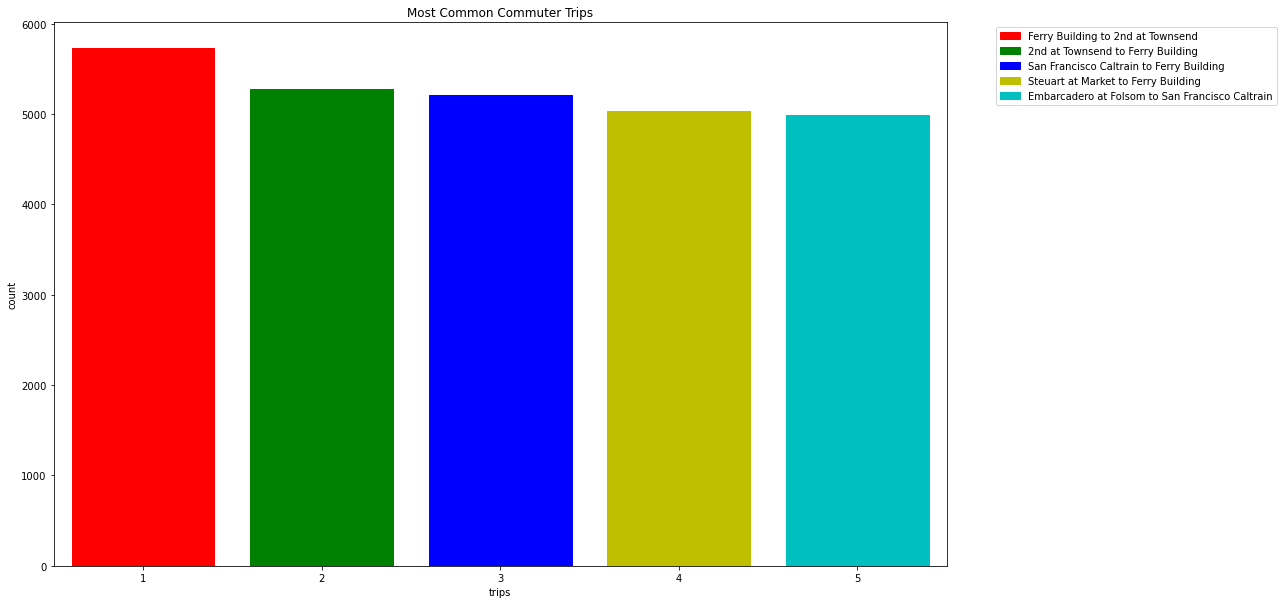

In [151]:
import matplotlib.patches as mpatches
x = top_c_trips['trips']
y = top_c_trips['count']
sns.set_context(rc={"figure.figsize": (8, 4)})
nd = np.arange(5)
width=0.8
plt.xticks(nd+width/2., ('1','2','3', '4', '5'))
plt.xlim(-0.15,3)
fig = plt.gcf()
fig.set_size_inches( 16, 10)

ax = sns.barplot(x=x, y=y)
ax.figsize=(60,60)
colors = ['r', 'g', 'b','y','c']
labels_dict = {
    1:"Ferry Building to 2nd at Townsend", 2: "2nd at Townsend to Ferry Building",
    3:"San Francisco Caltrain to Ferry Building", 4:"Steuart at Market to Ferry Building",
    5: "Embarcadero at Folsom to San Francisco Caltrain"
}
handles = []
for col, lab, patch in zip(colors, x, ax.axes.patches):
    patch.set_color(col)
    handles.append(mpatches.Patch(color=col,label=labels_dict[lab]))

ax.legend(handles=handles,bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Most Common Commuter Trips')
plt.show()


# Data to Make Business Recommendation

### Now I will plot the bikeshare stations on a map of San Francisco to see where they are located to get a better idea about who uses them.

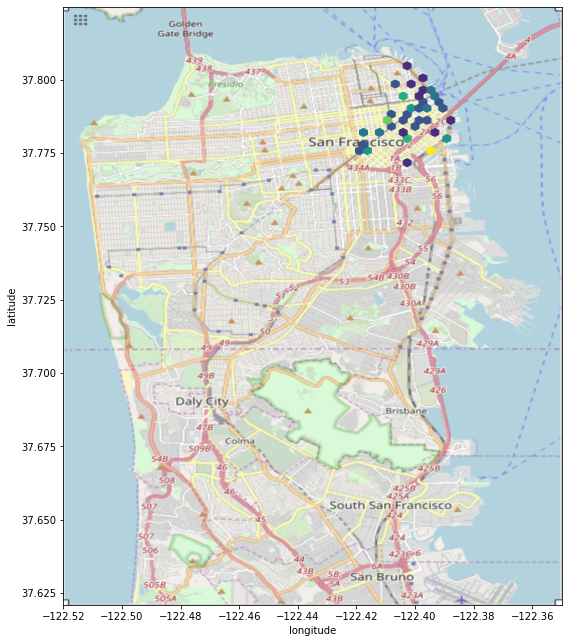

In [141]:
#Get min/max longitude and latitude for bike stations
# filt_bikeshare_stations = bikeshare_station[(bikeshare_station['name']=='Harry Bridges Plaza (Ferry Building)') 
#                                             | (bikeshare_station['name']=='2nd at Townsend')|(bikeshare_station['name']=='2nd at Townsend')
#                                            |(bikeshare_station['name']=='San Francisco Caltrain (Townsend at 4th')
#                                              |(bikeshare_station['name']=='Steuart at Market')|(bikeshare_station['name']=='Embarcadero at Folsom')]

min_lon = bikeshare_station['longitude'].min()
max_lon = bikeshare_station['longitude'].max()
min_lat = bikeshare_station['latitude'].min()
max_lat = bikeshare_station['latitude'].max()
# min_lon = filt_bikeshare_stations['longitude'].min()
# max_lon = filt_bikeshare_stations['longitude'].max()
# min_lat = filt_bikeshare_stations['latitude'].min()
# max_lat = filt_bikeshare_stations['latitude'].max()

bound = ((min_lon, max_lon, min_lat, max_lat)) #makes bounds for map
min_lon, max_lon, min_lat, max_lat
map_bound = ((-122.5200, -122.3500, 37.6209, 37.8249))


basemap = plt.imread('sf.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])



# Create the hexbin plot
hexbin_plot = ax.hexbin(x = bikeshare_station['longitude'], y = bikeshare_station['latitude'], C = bikeshare_station['dockcount'],
                         reduce_C_function = np.sum, gridsize = 200)

plt.xlabel('longitude')
plt.ylabel('latitude')
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');

The existing stations are located in and around the Financial District which is home to the majority of businesses in San Francisco. The bikeshare stations appear to be located near Bay Area Rapid Transportation (BART) stops. Many users of the bikeshare service likely commute into San Francisco with BART or with the CalTrain which connects the South Bay to San Francisco. The data on the most common commuter trips supports this hypothesis. The locations are located in strategic areas for commuters. However, some bikeshare stations located more to the south and to the west would better connect commuters to all of San Francisco. I would recommend opening a station near Daly City, San Bruno, and Balboa Park to connect commuters who work in South San Francisco.

## The Breakdown of Subscribers to Users 

In [142]:
# Break down of subscribers to users
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > subscribers.csv
subscribers_dta = pd.read_csv('subscribers.csv')
sub_cust = subscribers_dta.groupby(['subscriber_type']).size().reset_index().rename(columns={0:'count'}).sort_values(by = 'count', ascending = False)
sub_cust = pd.DataFrame(sub_cust)
sub_cust


Waiting on bqjob_r6fd5c44fd15f9bbf_00000174d5f35c00_1 ... (0s) Current status: DONE   


,subscriber_type,count
1,Subscriber,846839
0,Customer,136809


Text(0.5, 1.0, 'Subscribers vs Customers')

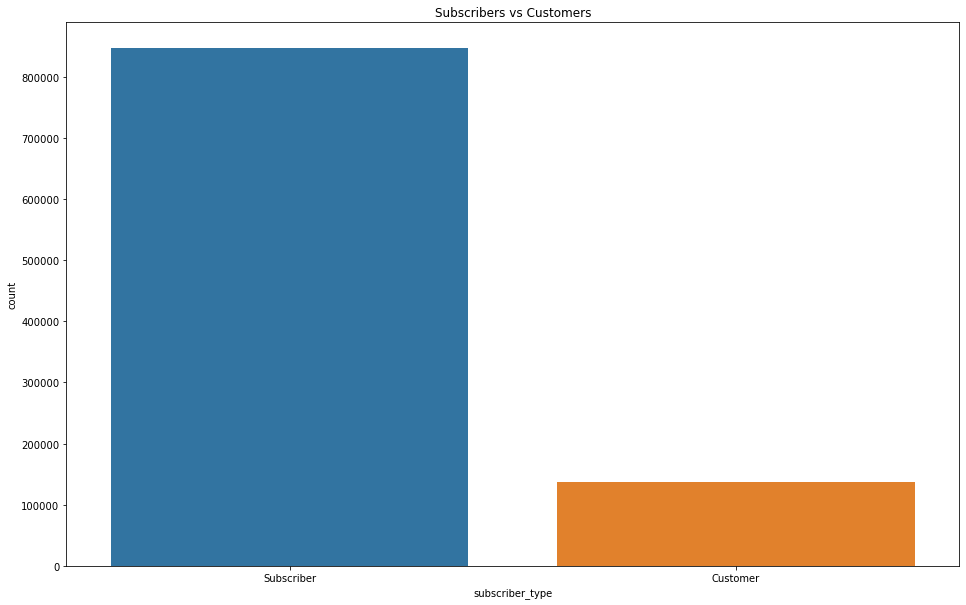

In [143]:
sub_type = sub_cust['subscriber_type']
count = sub_cust['count']
fig = plt.gcf()
fig.set_size_inches( 16, 10)
sns.barplot(sub_type, count).set_title('Subscribers vs Customers')

The vast majority of users are subscribers. There is likely a large financial incentive to becoming a subscriber and/or people sign up planning on frequently using the service.

## How does use vary during the day and by day of the week?

In [144]:
# Read in query
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'select dow, start_hour, avg(number_trips) as avg_trips from (SELECT start_date, EXTRACT(DAYOFWEEK FROM start_date) as dow, EXTRACT(HOUR FROM start_date) AS start_hour, count(*) as number_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` group by start_date, dow, start_hour) group by dow, start_hour order by 1, 2' > trips_per_day.csv
avg_trips_p_day = pd.read_csv('trips_per_day.csv') #read data into pandas data frame
avg_trips_p_day.head()

Waiting on bqjob_r7f85b04b09e76665_00000174d5f3ab05_1 ... (0s) Current status: DONE   


,dow,start_hour,avg_trips
0,1,0,1.130769
1,1,1,1.151163
2,1,2,1.126214
3,1,3,1.061224
4,1,4,1.037037


In [145]:
def dow_int_str(data):
    "Converts DOW integer into String"
    if data['dow'] == 1:
        return "Sunday"
    elif data['dow'] ==2:
        return "Monday"
    elif data['dow'] == 3:
        return "Tuesday"
    elif data['dow'] ==4:
        return "Wednesday"
    elif data['dow'] ==5:
        return "Thursday"
    elif data['dow'] == 6:
        return "Friday"
    else:
        return "Saturday"

avg_trips_p_day['dow_str'] = avg_trips_p_day.apply(dow_int_str, axis = 1) #adds string dow
sorted_avg_trips = avg_trips_p_day.sort_values('avg_trips', ascending = False)
sorted_avg_trips = sorted_avg_trips.drop(columns= ['dow']).head(20)
sorted_avg_trips = sorted_avg_trips[['dow_str', 'start_hour', 'avg_trips']]
sorted_avg_trips

,dow_str,start_hour,avg_trips
56,Tuesday,8,3.318160
80,Wednesday,8,3.250751
104,Thursday,8,3.201723
32,Monday,8,3.158267
41,Monday,17,3.003404
65,Tuesday,17,2.988379
89,Wednesday,17,2.940826
128,Friday,8,2.865325
113,Thursday,17,2.865290
137,Friday,17,2.564213


### Let's use a lineplot to better understand how use varies by day of the week and by 

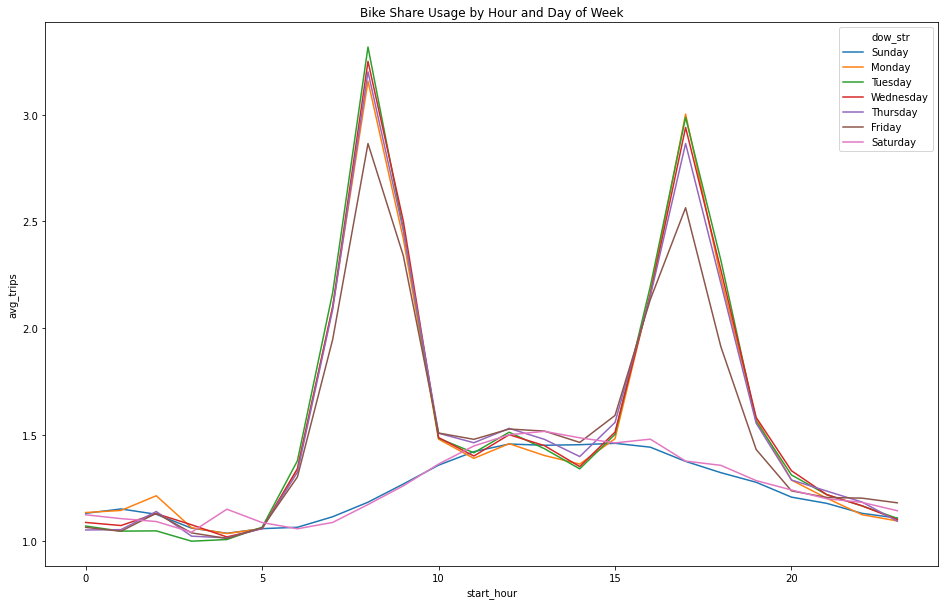

In [149]:
# make lineplot with sns.lineplot
sns.lineplot(data = avg_trips_p_day, x = 'start_hour', y = 'avg_trips', hue = 'dow_str' ).set_title('Bike Share Usage by Hour and Day of Week')
fig = plt.gcf()
fig.set_size_inches( 16, 10)

Usage peaks at commuting times. The largest quantity of trips are between 7am and 9am and between 4pm and 7pm. During the weekend, there is not a strong peak at any time. Unfortunately, it seems like the bike share service is not highly used. 

#### How many bikes are there?

In [147]:
! bq query --use_legacy_sql=FALSE --max_rows=1000000 'SELECT COUNT(DISTINCT(bike_number)) as Number_of_bikes FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r5c0a2e017d9a3b7e_00000174d5f3b45e_1 ... (0s) Current status: DONE   
+-----------------+
| Number_of_bikes |
+-----------------+
|             700 |
+-----------------+


Only a small fraction of the available bikes are in use even during peak hours. The highest usage of the bikeshare service is on Tuesdays at 8am and only $\frac{3.32}{700}$ bikes are in use.

## How much time is spent on bike share trips?

In [169]:
#read in data from big query
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT duration_sec  FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > trip_duration.csv
duration = pd.read_csv('trip_duration.csv')
duration.head()

Waiting on bqjob_r440a9579196e2c_00000174d690bd64_1 ... (0s) Current status: DONE   


,duration_sec
0,2618
1,5957
2,5913
3,6079
4,5780


### What is the median and the average amount of time spent on a bike trip?

In [170]:
#Remove unreasonable times(less than 4 minutes and greater than five hours)
duration_filt = duration.query('240 <= duration_sec <=18000')
average = duration_filt.mean()
print(average/60) #divide by 60 to give average time in minutes
median = duration_filt.median()
median/60

duration_sec    13.969947
dtype: float64


duration_sec    9.216667
dtype: float64

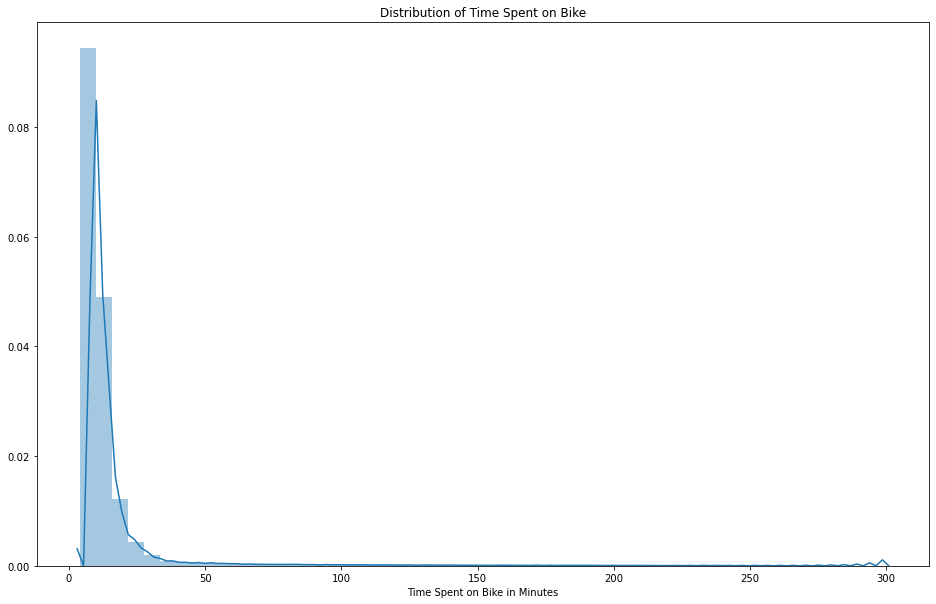

In [178]:
y = duration_filt['duration_sec']/60
x = pd.Series(y, name="Time Spent on Bike in Minutes")
sns.distplot(x).set_title('Distribution of Time Spent on Bike')
fig = plt.gcf()
fig.set_size_inches( 16, 10)

Most trips are between 4 minutes and 30 minutes. There is a long tail on the distribution for trips of longer duration.

## Executive Summary

1. Currently, the bikeshare service is substantially under utilized. There are 700 total bikes and during peak commuter times, only a handful of bikes are in use. 
2. 86% of bike share users are subscribers. Although most users are subsribers, their usage is very low.
3. Commuters make up the majority of bike share users. There is a clear peak before 9:00am and before 7:30pm during weekdays. On the weekend, there is not a defined peak.
4. The current bikeshare locations are strategic. They are located near BART stations and have high coverage in San Francisco's business sectors.
5. The vast majority of trips are of short duration. The average trip is 14 minutes and the median trip is 9 minutes.

## Recommendation

1. Conduct social media marketing campaign targeting individuals who commute to San Francisco for work
2. Determine the price elasticity- randomly select subscribers and contact them with different promotions and see how price affects usage
3. Contact subscribers with different incentive strategies
    - a fitness challenge: reach X miles and receive promotional pricing
    - a challenge to reduce green house gasses from other modes of transportation
4. Create strategic partnerships with San Francisco based companies to provide special pricing and promotions to employees
    - Conduct company wide biking challenges
5. Experiment with electric bikes to make commuting more practical in hilly San Francisco
6. Include more stations in the south of San Francisco to improve practicality in the South
7. Conduct a focus group amongst subscribers to learn more about changes that would encourage them to use the service
8. Make the bikes more comfortable to encourage longer use time.